**Microarray Cancer Classification  -- Predicting the Stages of Cancer**

Google Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load and Preprocess the Data

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
data = pd.read_csv('/content/combined.csv')
data = data[(data['Grade'] == 2) | (data['Grade'] == 3)]  # Keep only Grade 2 and Grade 3
image_dir = '/content/drive/MyDrive/final_images2'
data['image_path'] = data['Position'].apply(lambda x: os.path.join(image_dir, f"{x}.png"))

# Check class distribution
print("Class distribution before balancing:")
print(data['Grade'].value_counts())

# Oversample Grade 3
grade_2 = data[data['Grade'] == 2]
grade_3 = data[data['Grade'] == 3]
grade_3_upsampled = resample(grade_3, replace=True, n_samples=len(grade_2), random_state=42)
balanced_data = pd.concat([grade_2, grade_3_upsampled])

print("Class distribution after balancing:")
print(balanced_data['Grade'].value_counts())

# Preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

X, y = [], []
for _, row in balanced_data.iterrows():
    img_array = preprocess_image(row['image_path'])
    if img_array is not None:
        X.append(img_array)
        y.append(row['Grade'])

X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical(y - 2)  # Convert labels to one-hot encoding

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Class distribution before balancing:
Grade
2    42
3    21
Name: count, dtype: int64
Class distribution after balancing:
Grade
2    42
3    42
Name: count, dtype: int64


Model Architecture

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two output classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Training with Data Augmentation

In [5]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6836 - loss: 1.0077 - val_accuracy: 0.6471 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.5918 - loss: 0.9327 - val_accuracy: 0.5294 - val_loss: 1.3312 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - accuracy: 0.5247 - loss: 1.3615 - val_accuracy: 0.5882 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - accuracy: 0.5633 - loss: 0.9615 - val_accuracy: 0.4118 - val_loss: 0.6410 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step - accuracy: 0.7647 - loss: 0.6307 - val_accuracy: 0.5294 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.6272 - loss: 0.7981 - val_accuracy: 0.5882 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.6571 - loss: 0.8621 - val_accuracy: 0.5882 - val_l

Model Evaluation

In [6]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5294 - loss: 0.6149
Test Loss: 0.6149
Test Accuracy: 0.5294
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.50      0.62      0.56         8

    accuracy                           0.53        17
   macro avg       0.54      0.53      0.53        17
weighted avg       0.54      0.53      0.53        17

Confusion Matrix:
 [[4 5]
 [3 5]]


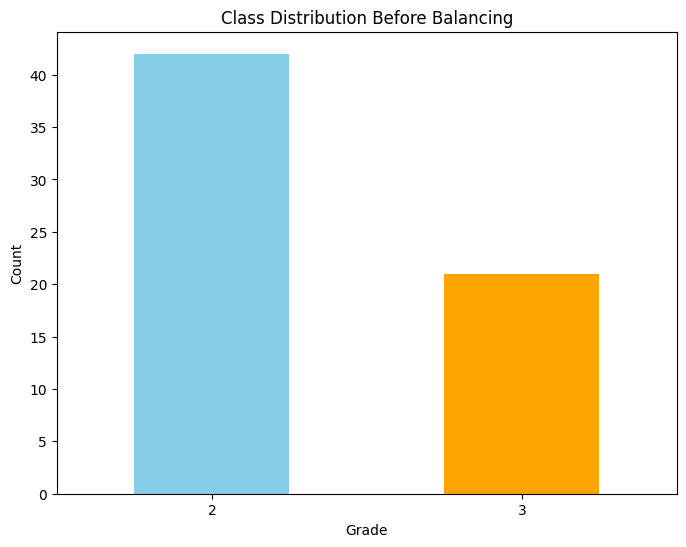

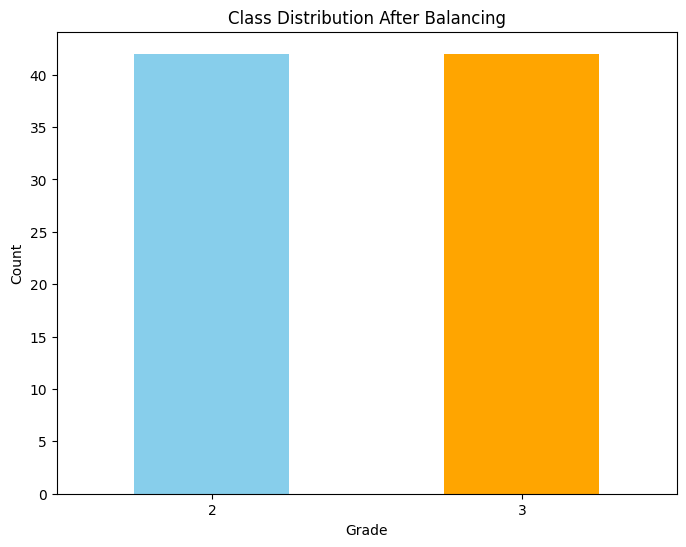

In [7]:
import matplotlib.pyplot as plt

# Class distribution before balancing
class_counts = data['Grade'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution Before Balancing")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Class distribution after balancing
balanced_class_counts = balanced_data['Grade'].value_counts()
plt.figure(figsize=(8, 6))
balanced_class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Class Distribution After Balancing")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


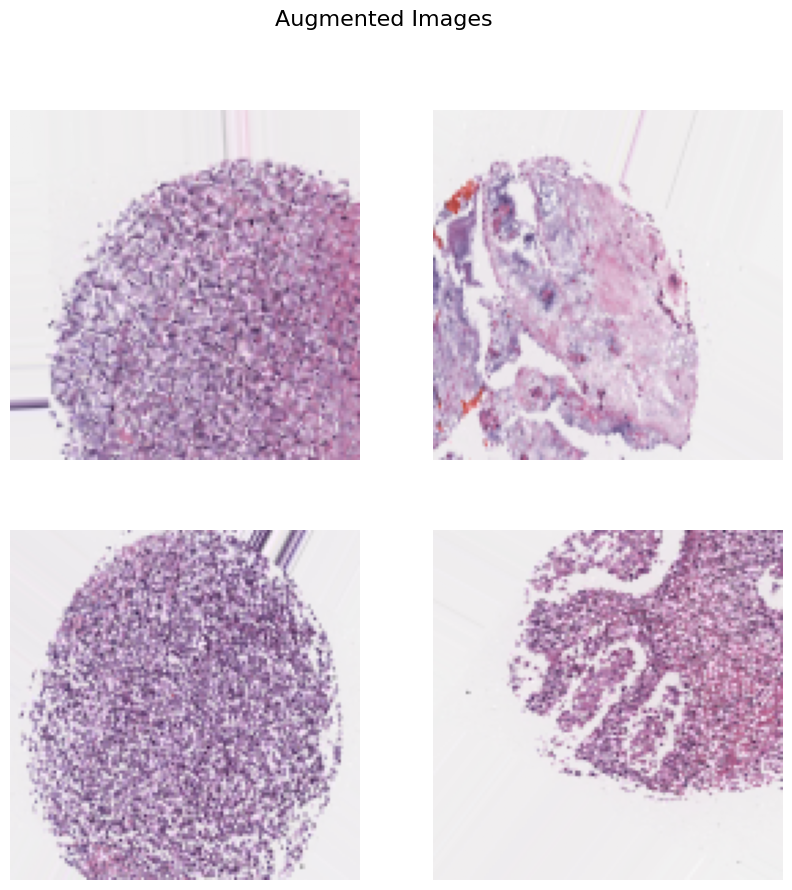

In [8]:
# Display augmented images
augmented_images, _ = next(datagen.flow(X_train, y_train, batch_size=4))

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


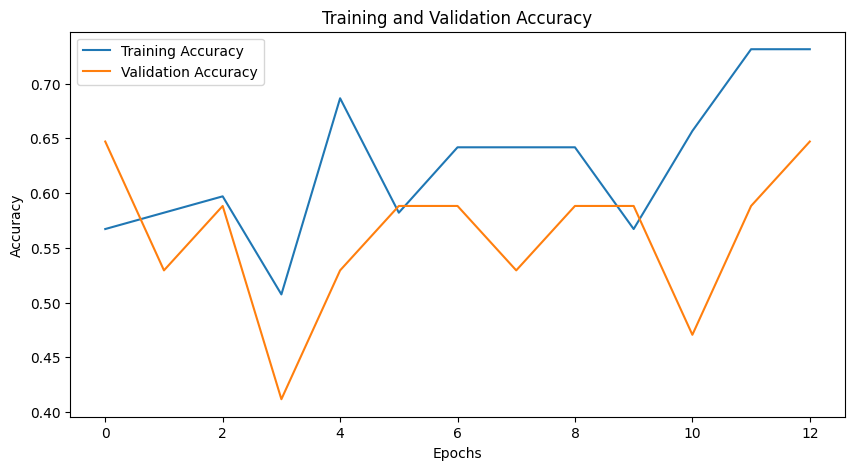

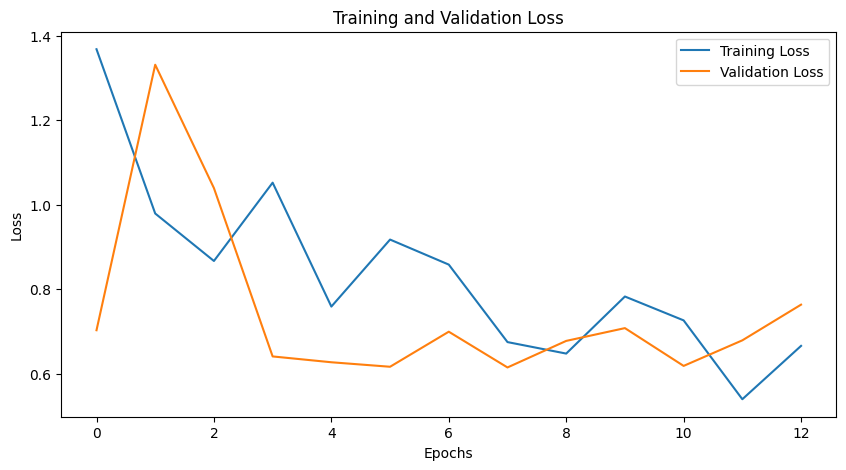

In [9]:
# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


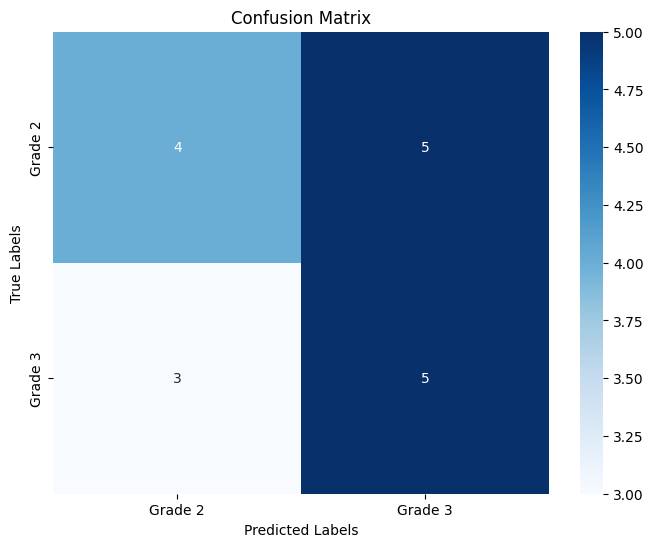

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Grade 2", "Grade 3"], yticklabels=["Grade 2", "Grade 3"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


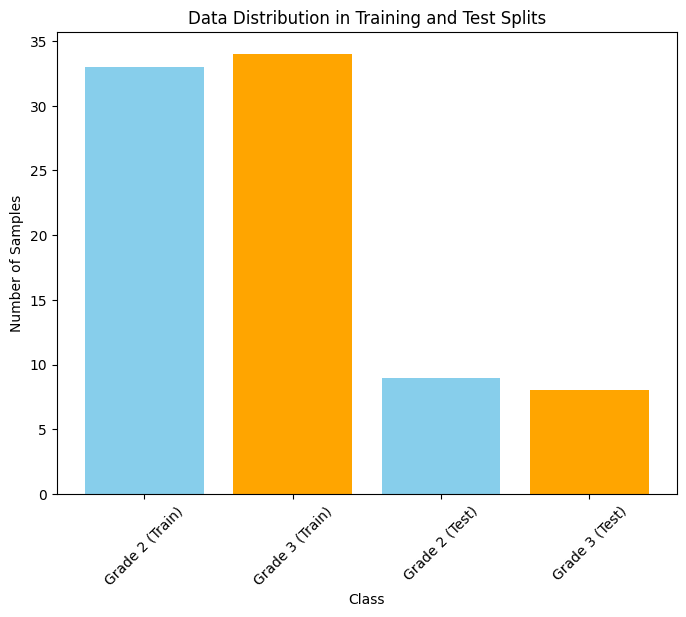

In [12]:
# Data distribution visualization
train_classes = np.argmax(y_train, axis=1)
test_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(8, 6))
plt.bar(["Grade 2 (Train)", "Grade 3 (Train)", "Grade 2 (Test)", "Grade 3 (Test)"],
        [sum(train_classes == 0), sum(train_classes == 1), sum(test_classes == 0), sum(test_classes == 1)],
        color=['skyblue', 'orange', 'skyblue', 'orange'])
plt.title("Data Distribution in Training and Test Splits")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


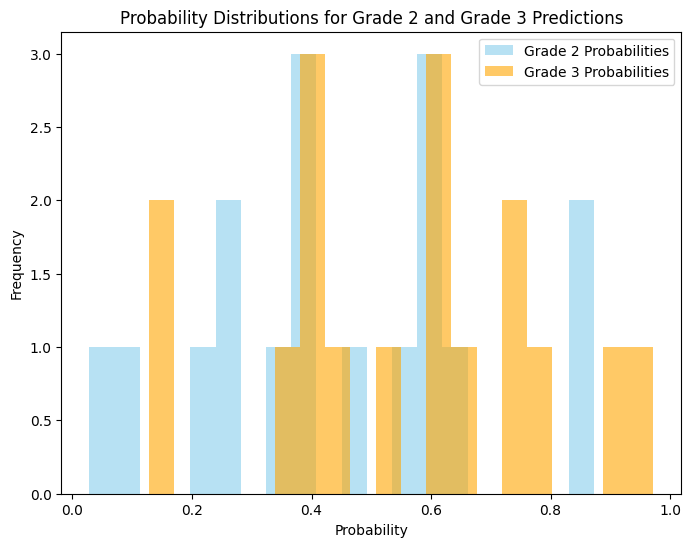

In [14]:
# Probability distributions for predictions
y_probs = model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.hist(y_probs[:, 0], bins=20, alpha=0.6, label="Grade 2 Probabilities", color='skyblue')
plt.hist(y_probs[:, 1], bins=20, alpha=0.6, label="Grade 3 Probabilities", color='orange')
plt.title("Probability Distributions for Grade 2 and Grade 3 Predictions")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


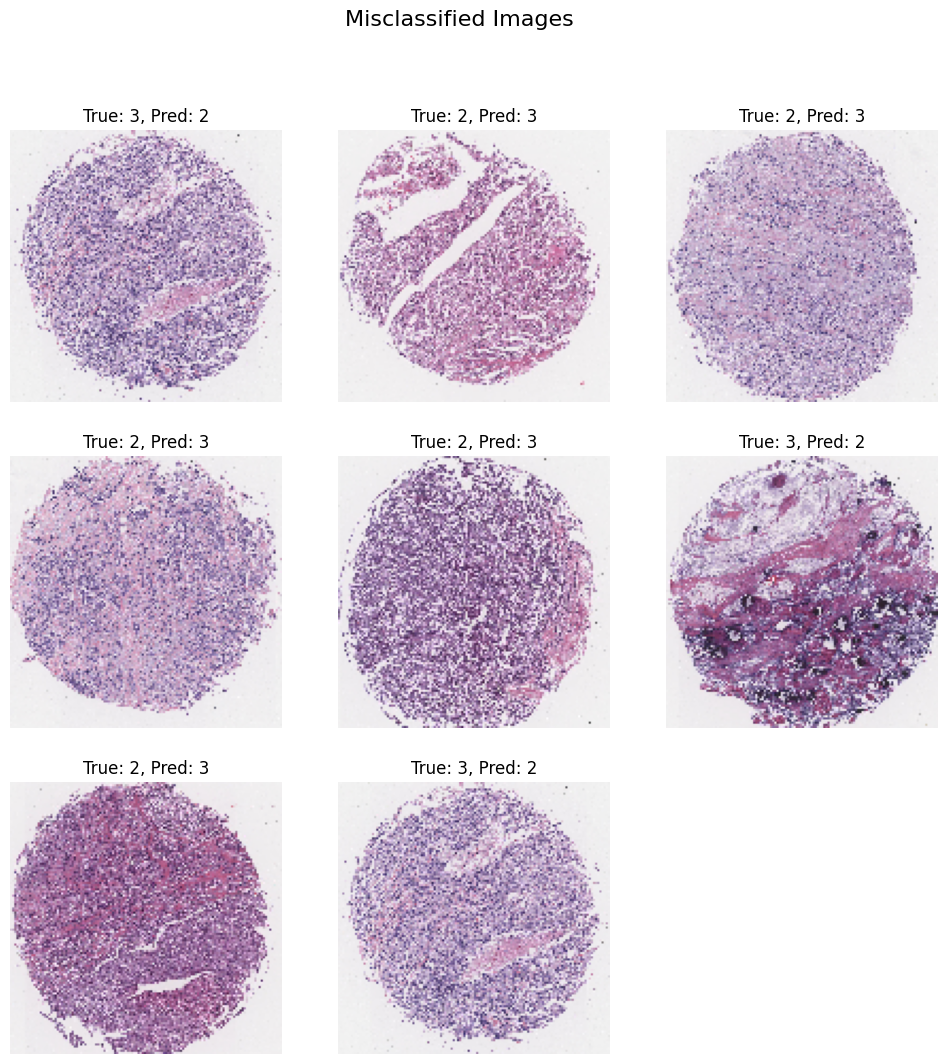

In [15]:
# Identify misclassified images
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:9]):  # Show first 9 misclassified images
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx] + 2}, Pred: {y_pred_classes[idx] + 2}")
    plt.axis('off')
plt.suptitle("Misclassified Images", fontsize=16)
plt.show()


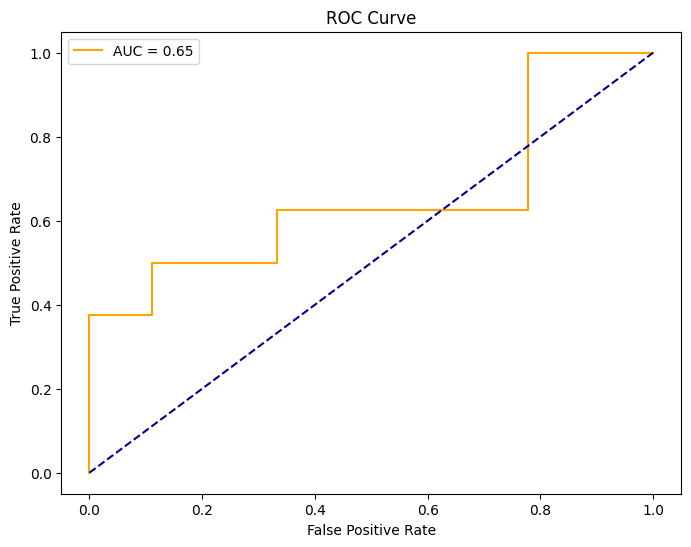

In [18]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_classes, y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


<Figure size 1000x500 with 0 Axes>

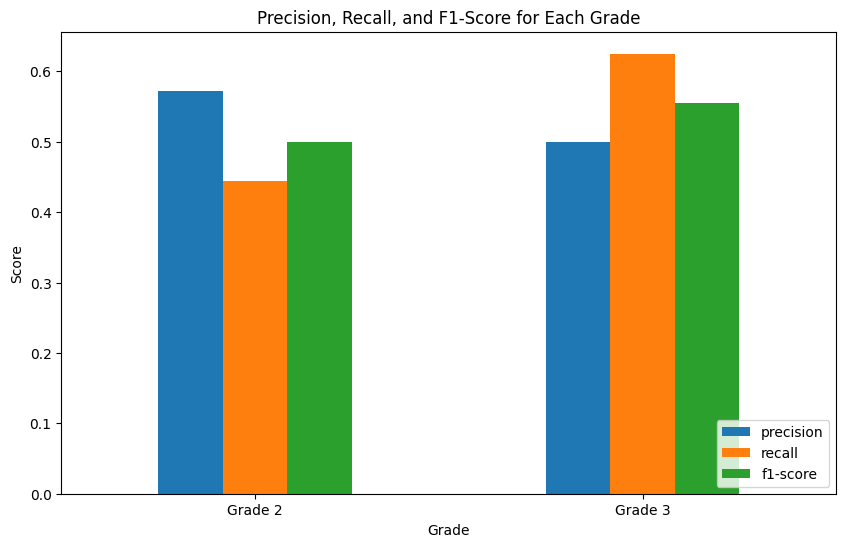

In [19]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report as a dataframe
report = classification_report(y_true_classes, y_pred_classes, target_names=["Grade 2", "Grade 3"], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot classification metrics
plt.figure(figsize=(10, 5))
report_df.loc[['Grade 2', 'Grade 3'], ['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, and F1-Score for Each Grade")
plt.ylabel("Score")
plt.xlabel("Grade")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


Prediction Function

In [20]:
def predict_grade(image_path, model_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        raise ValueError("Error processing image.")

    # Load trained model
    model = tf.keras.models.load_model(model_path)

    # Predict grade
    prediction = model.predict(np.expand_dims(img_array, axis=0))
    grade = np.argmax(prediction, axis=-1)[0] + 2

    print(f"Predicted Stage: {grade}")
    return grade

# Example Usage
model_path = '/content/drive/MyDrive/breast_cancer_grade_model.h5'
image_path = '/content/drive/MyDrive/final_images2/A2.png'
predicted_grade = predict_grade(image_path, model_path)
print(f"The predicted stage for the image is: {predicted_grade}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted Stage: 3
The predicted stage for the image is: 3
